# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

importiamo il modello Holistic di MediaPipe

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

ora visualizziamo i landmark graficamente, in maniera standard; li renderizziamo -> saranno visibili a schermo

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

#le X_CONNECTIONS sono mappe che restituiscono i legami fra i vari landmark

formattiamo, personalizziamo i landmark in maniera grafica

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

cicliamo su tutti i frame del video

In [ ]:
cap = cv2.VideoCapture(0) #accediamo alla nostra webcam
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:
    while cap.isOpened(): #finchè webcam attiva...

        # Read feed
        ret, frame = cap.read() #prendiamo il singolo frame

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks to the screen in real time 
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): #se premiamo q -> quit
            break
    cap.release()
    cv2.destroyAllWindows()

In [9]:
# coordinate/dati circa i landmark dell'ultimo frame estratto
len(results.face_landmarks.landmark)

468

disegniamo/visualizziamo i landmark sul frame estratto

In [10]:
draw_styled_landmarks(frame, results)

In [11]:
draw_landmarks(frame, results)

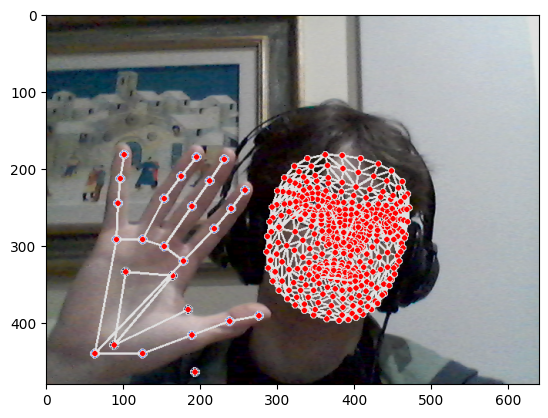

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

restituisce il numero dei landmark usati per la parte del corpo specificata

In [13]:
len(results.right_hand_landmarks.landmark)

21

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

In [14]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

Facciamo la stessa cosa, ma tutto su una sola linea.

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

In [15]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

#moltiplichiamo tutto per 3|4 perchè dobbiamo tenere conto di tutte e tre le coordinate (x,y,z) e del parametro visibility, dove presente

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

qui facciamo quello fatto sopra, ma in maniera pù organizzata, in una funzione apposita:

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [18]:
result_test = extract_keypoints(results)
extract_keypoints(results).shape

(1662,)

### abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

In [55]:
result_test

NameError: name 'result_test' is not defined

salviamo e carichiamo i keypoints appena estratti 

in pratica salveremo ogni frame sottoforma di array

In [20]:
np.save('0', result_test)

In [8]:
np.load('0.npy')

array([ 0.60391432,  0.61738485, -1.23808539, ...,  0.15823931,
        0.38068616, -0.04581715])

# 4. Setup Folders for Collection

avremo la seguente struttura: 3 azioni -> 30 video per azione -> 30 frame per ciascuna azione -> ogni frame contiene un array di dati, in particolare 1662 keypoints per frame. In generale:

- AZIONI
    - VIDEO
        - FRAME


cioè:


- *azione_1*
    - *1*
    - *...*
    - *29*
        - *array_1*
        - *...*
        - *array_29*
    

- *azione_2*
    - *1*
    - *...*
    - *29*
        - *array_1*
        - *...*
        - *array_29*

- *...*

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') # accediamo ai keypoints estratti sopra

# Actions that we try to detect
actions = np.array(['manoDelGaucho', 'cannoneDiTensing', 'ciao'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30 #usiamo 30 frame, ciascuno con 1662 keypoints da valutare

# avremo quindi 30 video; ciascuno di 30 frame; moltipl. per 3 azioni possibili; moltipl. per 1662 keypoints per ogni frame

In [22]:
for action in actions: 
    for sequence in range(no_sequences): #da 0 a 29
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass #se esistono già, skippa la creazione

# 5. Collect Keypoint Values for Training and Testing

come nella sezione 2., ma ora cicliamo per ogni azione, poi per ogni video, poi per ogni frame

COME?   se il frame è quello iniziale (zero), stampa a schermo del testo e metti in pausa per 2 secondi

In [ ]:
cap = cv2.VideoCapture(0) # uso la videocamera del pc
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

creiamo un dizionario dove salviamo tutte le azioni/gesti:

In [10]:
label_map = {label:num for num, label in enumerate(actions)} #iteriamo su ciascuna azione

In [11]:
label_map

{'manoDelGaucho': 0, 'cannoneDiTensing': 1, 'ciao': 2}

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

- **sequences** avrà 90 video al suo interno (30 x 3 azioni), ciascuno di 30 frame, ognuno con 1662 keypoints
    - quindi sarà un array *tridimensionale*: (90, 30, 1662)

In [ ]:
action = "ciao"
sorted(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int)) #restituisce gli indici dei video per l'action specificata

In [17]:
sequences, labels = [], [] # rispettivamente X (feature input) e Y (feature target)
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int): #cast str to int
        window = [] #rappresenta un unico video: insieme di 30 frame

        for frame_num in range(sequence_length): #per 30 frame            
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(label_map[action]) #ci saranno 90 video al suo interno,
        # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

In [ ]:
sequences

In [ ]:
window

In [22]:
np.array(window).shape # 1 video (l'ultimo) | 30 frame | 1662 keypoints 

(30, 1662)

In [21]:
np.array(sequences).shape # 90 video | 30 frame | 1662 keypoints

(90, 30, 1662)

In [54]:
np.array(labels).shape

(90,)

In [26]:
X = np.array(sequences)

In [27]:
X.shape

(90, 30, 1662)

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [19]:
y = to_categorical(labels).astype(int)

splittiamo i dati in Training Sets e Test Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05,stratify=y)

In [21]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [36]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [37]:
# il modello Sequential ci permette di aggiungere layer in mainera organizzata e facile
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è neecessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [38]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [39]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 14s 262ms/step - loss: 11.0848 - categorical_accuracy: 0.3529
Epoch 2/500
3/3 [==============================] - 1s 233ms/step - loss: 7.3357 - categorical_accuracy: 0.4235
Epoch 3/500
3/3 [==============================] - 1s 175ms/step - loss: 15.2477 - categorical_accuracy: 0.2588
Epoch 4/500
3/3 [==============================] - 1s 173ms/step - loss: 17.9987 - categorical_accuracy: 0.3529
Epoch 5/500
3/3 [==============================] - 1s 175ms/step - loss: 28.6436 - categorical_accuracy: 0.3765
Epoch 6/500
3/3 [==============================] - 1s 229ms/step - loss: 22.9225 - categorical_accuracy: 0.4471
Epoch 7/500
3/3 [==============================] - 1s 168ms/step - loss: 35.0479 - categorical_accuracy: 0.3294
Epoch 8/500
3/3 [==============================] - 1s 168ms/step - loss: 37.8790 - categorical_accuracy: 0.3059
Epoch 9/500
3/3 [==============================] - 1s 170ms/step - loss: 35.5102 - categorical_accuracy:

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

⬆️ vediamo come i parametri totali sono mezzo milione circa, molti meno di quanti ne avremmo se usassimo un Convolutional Neural Network (CNN)

# 8. Make Predictions

In [41]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

1/1 [==============================] - 1s 1s/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [57]:
actions[np.argmax(res[4])] #qual'è l'azione con il più altro valore di probabilità associato?

'manoDelGaucho'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [56]:
actions[np.argmax(y_test[4])]

'ciao'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [59]:
model.save('action.h5')

In [46]:
del model

In [60]:
model.load_weights('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [62]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 70ms/step


In [63]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [64]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [1, 0]],

       [[0, 4],
        [0, 1]],

       [[2, 0],
        [3, 0]]], dtype=int64)

In [65]:
accuracy_score(ytrue, yhat)

0.2

# 11. Test in Real Time

In [58]:
from scipy import stats

In [59]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [60]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [69]:
# 1. New detection variables
sequence = [] #raccogliamo 30 frame alla volta per poi fare una prediction
sentence = [] #concateniamo tutte le predictions ottenute
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] #prendiamo gli ultimi 30 frames
        
        if len(sequence) == 30: #facciamo prediction solo se abbiamo 30 frame a disposizione
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #vogliamo 3 dim (num_sequenze, frame, keypoints), ne abbiamo 2 (frame, keypoints)
            print(actions[np.argmax(res)])                           #facciamo così perchè possiamo passare una sola sequenza e non un insieme..
            predictions.append(np.argmax(res))                       #..di frame come facevamo nella parte 8.
            #usiamo append() perchè vogliamo ultimi 30
            #altrimenti insert(), ma dovremmo prendere invece i primi 30
            
        #3. Visualization logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti